In [1]:
# !pip install -U scikit-learn shap pandas numpy

In [2]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = None

C:\Users\sasha\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\sasha\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\sasha\anaconda3\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
import sklearn
sklearn.set_config(display='diagram') # switch on pipeline visualisation
# from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
# from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import GridSearchCV, train_test_split

# Task

<div class="alert alert-warning">
    

Please take a look and design a solution that would provide size recommendations for users of that brand, based on this data (or anything else you want to use in addition). You can decide what input from shoppers you want to use in order to make a recommendation.

In [4]:
df = pd.read_csv('shoppers_feedback.csv', sep = '\t').drop('Purchased product gender', axis = 1) 
print(df.shape)
df.drop_duplicates(inplace=True, ignore_index = True) # drop duplicates
print(df.shape)

# fix waste in product type columns
change_type_dict = {'Alle produkter,EVERY,Overdele' : 'Toppe', 'Alle produkter,Buksedragter' : 'Buksedragter',
                    'Alle produkter,Buksedragter,EVERY' : 'Buksedragter', 'Alle produkter,Kjoler':'Kjoler',
                    'Alle produkter,Bukser' : 'Bukser', 'Alle produkter,Nederdele':'Nederdele'}

df['Purchased product type'] = df['Purchased product type'].apply(lambda x : change_type_dict.get(x, x))
df['Purchased product type'].value_counts()

df.sample(2)

(398, 31)
(312, 31)


,User height,User chest shape,User belly shape,User hips shape,User leg shape,User preferred bottoms fit,User preferred tops fit,User most common top size,"User top size tendency (whether or not they sometimes by bigger/smaller size, instead of their most common)",User most common bottoms size,"User bottoms size tendency (whether or not they sometimes by bigger/smaller size, instead of their most common)",User fit challenges with tops legth,User fit challenges,User fit challenges with sleeves\,User fit challenges with chest fit,User fit challenges with waist fit,User fit challenges with waistband fit,User fit challenges with hips fit,User fit challenges with thighs fit,Purchased product ID,Purchased size,Purchased product overall fit,Purchased product overall fit overall length,Purchased product overall size,Purchased product sleeve fit,Purchased product chest fit,Purchased product waistband fit,Purchased product waist fit,Purchased product hip fit,Purchased product thigh fit,Purchased product type
166,163,broad,round,NaN,NaN,NaN,loose,46,smaller,NaN,NaN,too_long,NaN,too_long,too_tight,too_tight,NaN,NaN,NaN,792,48,loose,good,good,good,good,NaN,loose,good,NaN,Buksedragter
161,176,slim,flat,wide,skinny,regular,regular,42,bigger,44.0,bigger,no_problem,too_short,too_short,no_problem,no_problem,no_problem,too_tight,no_problem,3607,40,loose,good,bigger,NaN,NaN,good,NaN,loose,loose,Bukser


# Some preporation for bulding target (Happiness)

<div class="alert alert-info">
    
we will penalize the example if the size turned out to be small or large and reward if it turned out to be good


In [5]:
# Features from which we will make a target

rank_features_target =  ['User fit challenges with tops legth','User fit challenges',
                         'User fit challenges with sleeves\\', 'User fit challenges with chest fit',
                         'User fit challenges with waist fit', 'User fit challenges with waistband fit',
                         'User fit challenges with hips fit', 'User fit challenges with thighs fit',
                         'Purchased product overall fit', 'Purchased product overall fit overall length',
                         'Purchased product overall size', 'Purchased product sleeve fit', 
                         'Purchased product chest fit',
                         'Purchased product waistband fit', 'Purchased product waist fit',
                         'Purchased product hip fit', 'Purchased product thigh fit']

rank_dict_target = {
    'no_problem': 1, 'good' : 1,
    'loose':  -1,  'bigger': -1, 'short' : -1, 'long' :  -1,
    'smaller' : -1.1, 'loose' : -1, 'tight' : -1, 'too_long' : -2,  'too_short' : -2,
    'too_big' : -2, 'too_small' : -2, 'too_loose' : -2, 'too_tight' : -2,
            }

In [6]:
# These features will not be included in the target, but will be converted

rank_features = ['User chest shape', 'User belly shape',
                 'User hips shape', 'User leg shape', 'User preferred bottoms fit',
                 'User preferred tops fit', 
                 'User top size tendency (whether or not they sometimes by bigger/smaller size, instead of their most common)',
                 'User bottoms size tendency (whether or not they sometimes by bigger/smaller size, instead of their most common)', 
                 ]


rank_dict = {'broad': 1,  'loose': 1,  'round': 1,  'wide' : 1, 'bigger': 1,
             'average': 0, 'regular' :  0,  'exact': 0,
             'slim': -1,  'flat' : -1,  'muscular': -1, 'skinny' : -1,
             'smaller' : -1, 'loose' : 1, 'tight' : -1, 
            }

## Feature Engineering

Here we will create some new useful features

In [7]:
def new_fs_function(data):
            
    data['diff_bottoms_top'] = data['User most common top size'] - data['User most common bottoms size']
    
    data['diff_bottoms_size'] = data['Purchased size'] - data['User most common bottoms size']
    data['diff_top_size'] = data['Purchased size'] - data['User most common top size']
    
#     data.fillna(0, inplace=True)
    return data
    
df = new_fs_function(df)
df.sample(3)

,User height,User chest shape,User belly shape,User hips shape,User leg shape,User preferred bottoms fit,User preferred tops fit,User most common top size,"User top size tendency (whether or not they sometimes by bigger/smaller size, instead of their most common)",User most common bottoms size,"User bottoms size tendency (whether or not they sometimes by bigger/smaller size, instead of their most common)",User fit challenges with tops legth,User fit challenges,User fit challenges with sleeves\,User fit challenges with chest fit,User fit challenges with waist fit,User fit challenges with waistband fit,User fit challenges with hips fit,User fit challenges with thighs fit,Purchased product ID,Purchased size,Purchased product overall fit,Purchased product overall fit overall length,Purchased product overall size,Purchased product sleeve fit,Purchased product chest fit,Purchased product waistband fit,Purchased product waist fit,Purchased product hip fit,Purchased product thigh fit,Purchased product type,diff_bottoms_top,diff_bottoms_size,diff_top_size
63,163,average,average,average,muscular,regular,regular,38,smaller,40.0,exact,too_short,too_long,too_long,too_tight,no_problem,no_problem,no_problem,no_problem,470,38,loose,good,bigger,good,good,NaN,loose,NaN,NaN,T-Shirts,-2.0,-2.0,0
231,172,slim,flat,NaN,NaN,NaN,regular,40,exact,NaN,NaN,too_short,NaN,no_problem,too_loose,no_problem,NaN,NaN,NaN,1166,40,loose,good,bigger,good,loose,NaN,loose,loose,NaN,Kjoler,NaN,NaN,0
253,167,average,average,NaN,NaN,NaN,regular,38,bigger,NaN,NaN,too_long,NaN,too_long,too_tight,too_tight,NaN,NaN,NaN,792,40,good,short,good,too_short,good,NaN,good,good,NaN,Buksedragter,NaN,NaN,2


# Here we create target or what is Happiness

<div class="alert alert-info">
    
To determine the level of happiness from the purchase, we highlight important columns for each type of clothing

In [8]:
type_fit_cols = {}
for tp in df['Purchased product type'].unique():
    print('-------', tp, '--------', df[df['Purchased product type']==tp].shape[0])
    sub_df = df[df['Purchased product type']=='T-Shirts']
    nulls = sub_df.isnull().sum()
    type_fit_cols[tp] = df.columns[nulls < 0.85*sub_df.shape[0] ].tolist() 

# type_fit_cols

------- T-Shirts -------- 57
------- Buksedragter -------- 87
------- Kjoler -------- 111
------- Nederdele -------- 11
------- Bukser -------- 17
------- Toppe -------- 29


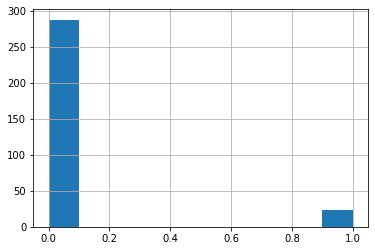

In [9]:
def make_target(d):
    target_cols = [c for c in type_fit_cols[d['Purchased product type']] if c in rank_features_target]
    
    d = d.copy()

    for c in rank_features:
        d[c] = rank_dict.get(d[c], d[c])
        
    for c in rank_features_target:
        d[c] = rank_dict_target.get(d[c], d[c])
    
    return d[target_cols].sum()/len(target_cols)
    
df['Happiness'] = df.apply(make_target, axis=1)

# apply min arget min - max scaling
df['Happiness'] = 1*(((df['Happiness'] - df['Happiness'].min())/(df['Happiness'].max() - df['Happiness'].min())) > 0.82)
df['Happiness'].hist();

# df.head()

# Features classification by types

In [10]:
numerical_features = [ 
    'User height',  'User most common top size', 
    'User most common bottoms size', 'Purchased size' ]

categorical_features = ['Purchased product type'] 

rank_features = [
    'User chest shape', 'User belly shape', 'User hips shape', 'User leg shape', 'User preferred bottoms fit', 'User preferred tops fit', 
    'User top size tendency (whether or not they sometimes by bigger/smaller size, instead of their most common)',
    'User bottoms size tendency (whether or not they sometimes by bigger/smaller size, instead of their most common)' ]

<div class="alert alert-info">
    
As input, we will use information that can be obtained from the user or from his purchase history.
    
    
**Note!** Yes, we do not know in advance what size the user will buy. We will use this feature to select the most probable size.

In [11]:
from sklearn.preprocessing import FunctionTransformer

# define function for dealing with rank features 
def rank_function(data):

    data = data.fillna(0).copy()

    for c in data.columns:
        data[c] = data[c].apply(lambda x : rank_dict.get(x, x)) 
    
    for c in data.columns:
        data[c] = data[c].apply(lambda x : rank_dict_target.get(x, x)) 

    return data

# Turning a Function into a Transformer
rank_transformer = FunctionTransformer(rank_function, validate=False)  


# how to apply to data
# rank_transformer.fit_transform(df).sample(5)

# Pipeline construction

In [12]:
#   For rank features 
ranker_transformer = Pipeline(steps=[#("imputer", SimpleImputer(fill_value = 0)),
                                      ("rank", rank_transformer),
#                                       ("scaler", StandardScaler()),
                                    ])


#   For numerical features - apply SimpleImputer, and then StandardScaler
numerical_transformer = Pipeline(steps=[ ("imputer", SimpleImputer(fill_value = 0)),
#                                          ("fs", SelectKBest(score_func=f_classif, k=2)),
                                       ])

#   For categorical features - apply SimpleImputer, and than OneHotEncoder
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

# Putting together transformers for numerical, rank and categorical features
data_transformer = ColumnTransformer(transformers=[
    ("numerical", numerical_transformer, numerical_features), # make_column_selector
    ("rank", ranker_transformer, rank_features),
    ("categorical", categorical_transformer, categorical_features),
])

# строим конвейера препроцессора, который сначала преобразует данные
preprocessor = Pipeline(steps=[("data_transformer", data_transformer)])

classifier_pipline = Pipeline(
    steps=[("preprocessor", data_transformer), 
           ("model",  RandomForestClassifier(n_jobs = -1, max_depth = 2, min_samples_leaf = 5,
                                             class_weight = 'balanced', n_estimators = 20))])


classifier_pipline.fit(df.drop('Happiness', axis=1).copy(), df['Happiness'])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0))]),
                                                  ['User height',
                                                   'User most common top size',
                                                   'User most common bottoms '
                                                   'size',
                                                   'Purchased size']),
                                                 ('rank',
                                                  Pipeline(steps=[('rank',
                                                                   FunctionTransformer(func=<function rank_function at 0x000001E0B679F5E0>))]),
                                                  ['User chest shape',
                                                   'User b...
                                                   '(whether or not they '
                                                   'sometimes by '
                                                   'bigger/smaller size, '
                                                   'instead of their most '
                                                   'common)']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Purchased product '
                                                   'type'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=2,
                                        min_samples_leaf=5, n_estimators=20,
                                        n_jobs=-1))])

# Model Tuning

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split 

parameters = {
             'model__max_depth':[2, 3, 4],
             'model__n_estimators':[10, 15, 20, 25],
             'model__min_samples_leaf':[3, 4, 5]
             }

clf = GridSearchCV(classifier_pipline, parameters, cv = 2, n_jobs = -1,
                   scoring = 'recall', verbose=True)
clf.fit(df.drop('Happiness', axis=1).copy(), df['Happiness'])

print(clf.best_score_)
print(clf.best_params_)

Fitting 2 folds for each of 36 candidates, totalling 72 fits
0.4166666666666667
{'model__max_depth': 2, 'model__min_samples_leaf': 3, 'model__n_estimators': 20}


# Training and Validation of Model

<div class="alert alert-info">
We will select a small part of the data for further testing and interpretation of the results

In [14]:
train, test = train_test_split(df, test_size = 0.13,
                               shuffle = True, random_state= 7575,
                               stratify = df['Happiness']
                              )

cols = numerical_features + rank_features + ['Happiness'] + ['Purchased product type']
classifier_pipline.fit(train.drop('Happiness', axis=1).copy(), train['Happiness'])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0))]),
                                                  ['User height',
                                                   'User most common top size',
                                                   'User most common bottoms '
                                                   'size',
                                                   'Purchased size']),
                                                 ('rank',
                                                  Pipeline(steps=[('rank',
                                                                   FunctionTransformer(func=<function rank_function at 0x000001E0B679F5E0>))]),
                                                  ['User chest shape',
                                                   'User b...
                                                   '(whether or not they '
                                                   'sometimes by '
                                                   'bigger/smaller size, '
                                                   'instead of their most '
                                                   'common)']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Purchased product '
                                                   'type'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=2,
                                        min_samples_leaf=5, n_estimators=20,
                                        n_jobs=-1))])

# Recommender bulding


<div class="alert alert-info">

Let's build a function that will produce model predictions and then output the top 6 best fit sizes in order of probability.

In [15]:
test['pred_class'] = classifier_pipline.predict(test.drop('Happiness', axis=1).copy())
test['pred_y'] = classifier_pipline.predict_proba(test.drop('Happiness', axis=1).copy())[:,1]


def size_recommender(new_user, d = {}, ton_n_size = 6):
    
    try:
        user_size = int(new_user['User most common top size'].values[0])
    except:
        user_size = int(new_user['User most common bottoms size'].values[0])
        
    for size in range(user_size-3, user_size+3, 1): # iterate through all sizes to choose the most suitable
        new_user['Purchased size'] = size
        new_user['diff_top_size'] = new_user['Purchased size'] - new_user['User most common top size']
        new_user['diff_bottoms_size'] = new_user['Purchased size'] - new_user['User most common bottoms size']
        
        k = abs((new_user['User most common bottoms size'].values[0]-size)*(new_user['User most common top size'].values[0]-size)/10)
        d[size] = round(classifier_pipline.predict_proba(new_user)[0,:][1], 5)*k
        
    return sorted(d, key = lambda x : d[x], reverse=True)[:ton_n_size]

sizes = [] 

for ix in test.index:
    new_user = pd.DataFrame(test.loc[ix]).T.copy()
    sizes.append(size_recommender(new_user))

test['recommend'] = sizes

# Take a look at results

## Positive examples

In [16]:
test[test.Happiness == 1][['User chest shape', 'User belly shape',
      'User hips shape', 'User leg shape', 'User preferred bottoms fit',
       'User preferred tops fit', 'User most common top size',
       'User top size tendency (whether or not they sometimes by bigger/smaller size, instead of their most common)',
       'User most common bottoms size',
       'User bottoms size tendency (whether or not they sometimes by bigger/smaller size, instead of their most common)',
        'Purchased product type',
       'Purchased size','Happiness',
        'pred_y',#'pred_class',
        'recommend']]#.dropna(axis=1).head(60)

,User chest shape,User belly shape,User hips shape,User leg shape,User preferred bottoms fit,User preferred tops fit,User most common top size,"User top size tendency (whether or not they sometimes by bigger/smaller size, instead of their most common)",User most common bottoms size,"User bottoms size tendency (whether or not they sometimes by bigger/smaller size, instead of their most common)",Purchased product type,Purchased size,Happiness,pred_y,recommend
31,average,average,NaN,NaN,NaN,regular,38,exact,NaN,NaN,T-Shirts,38,1,0.666546,"[37, 38, 39, 40, 41, 35]"
83,slim,average,NaN,NaN,NaN,regular,38,exact,NaN,NaN,T-Shirts,36,1,0.633909,"[37, 38, 39, 40, 41, 42]"
100,broad,round,NaN,NaN,NaN,regular,46,smaller,NaN,NaN,Buksedragter,46,1,0.300611,"[37, 38, 39, 40, 41, 42]"


<div class="alert alert-info">
    
Here we see that among the top 3 predicted sizes, there are sizes that the user was satisfied with.

## Negative examples

In [17]:
test[test.Happiness == 0][['User chest shape', 'User belly shape',
      'User hips shape', 'User leg shape', 'User preferred bottoms fit',
       'User preferred tops fit', 'User most common top size',
       'User top size tendency (whether or not they sometimes by bigger/smaller size, instead of their most common)',
       'User most common bottoms size',
       'User bottoms size tendency (whether or not they sometimes by bigger/smaller size, instead of their most common)',
        'Purchased product type',
       'Purchased size','Happiness',
        'pred_y',#'pred_class',
        'recommend']].sample(6, random_state= 42)

,User chest shape,User belly shape,User hips shape,User leg shape,User preferred bottoms fit,User preferred tops fit,User most common top size,"User top size tendency (whether or not they sometimes by bigger/smaller size, instead of their most common)",User most common bottoms size,"User bottoms size tendency (whether or not they sometimes by bigger/smaller size, instead of their most common)",Purchased product type,Purchased size,Happiness,pred_y,recommend
296,slim,flat,NaN,NaN,NaN,regular,40,bigger,NaN,NaN,Buksedragter,38,0,0.554990,"[37, 38, 39, 40, 41, 42]"
162,slim,flat,wide,skinny,regular,regular,42,bigger,44.0,bigger,T-Shirts,34,0,0.470077,"[37, 38, 39, 35, 36, 33]"
267,broad,flat,NaN,NaN,NaN,regular,40,bigger,NaN,NaN,Toppe,42,0,0.590600,"[37, 38, 39, 40, 41, 42]"
37,broad,round,NaN,NaN,NaN,regular,44,smaller,NaN,NaN,Buksedragter,44,0,0.367739,"[37, 38, 39, 40, 41, 42]"
90,broad,average,NaN,NaN,NaN,regular,42,smaller,NaN,NaN,T-Shirts,42,0,0.469431,"[37, 38, 39, 40, 41, 42]"
15,broad,average,average,muscular,regular,slim,40,bigger,40.0,exact,Toppe,38,0,0.601873,"[37, 33, 46, 38, 42, 34]"


<div class="alert alert-info">
    
Here we see that our model does not offer sizes that the user was dissatisfied with.

# Model Interpretation

In [18]:
# create column names for categorical hot encoded data
columns_names_to_map = list(np.copy(numerical_features))
columns_names_to_map.extend(col for col in rank_features)
columns_names_to_map.extend('cat1_' + str(col) for col in pd.get_dummies(train[categorical_features]).columns)


preproceed_train = pd.DataFrame({col:vals for vals, col in zip (preprocessor.fit_transform(train).T, columns_names_to_map)})
preproceed_test = pd.DataFrame({col:vals for vals, col in zip (preprocessor.transform(test).T, columns_names_to_map)})
preproceed_test['Happiness'] = test['Happiness'].values
# preproceed_test['recommend'] = test['recommend'].values

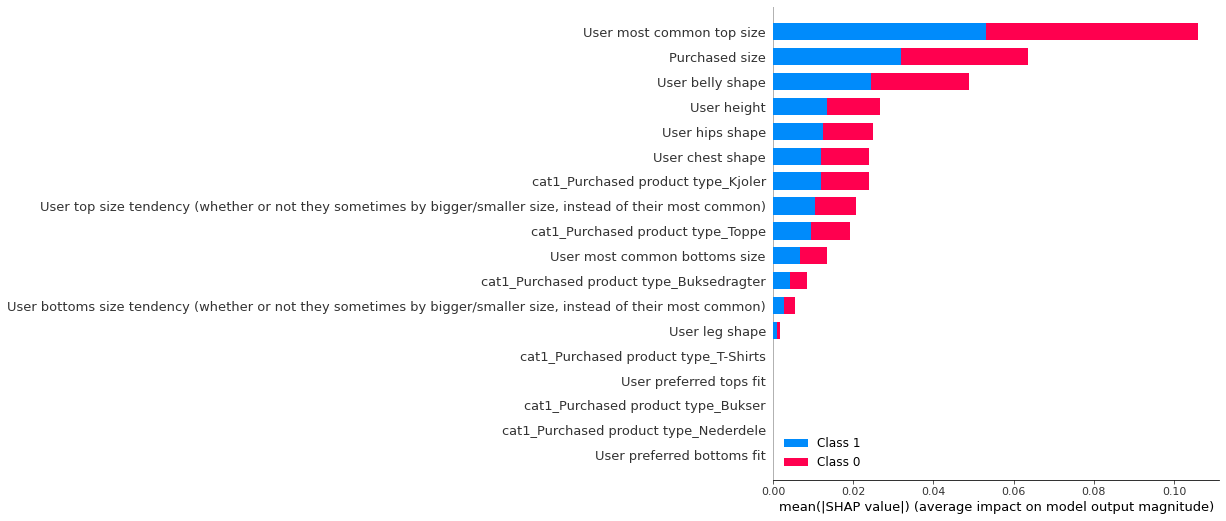

In [19]:
import shap

#load JS vis in the notebook
shap.initjs() 

#set the tree explainer as the model of the pipeline
explainer = shap.TreeExplainer(classifier_pipline['model'])

#apply the preprocessing to x_test
observations = preproceed_test.drop('Happiness', axis=1).values # classifier_pipline['preprocessor'].transform(test[cols])
#get Shap values from preprocessed data
shap_values = explainer.shap_values(observations)

#plot the feature importance
shap.summary_plot(shap_values, plot_type="bar", feature_names = preproceed_train.columns)

<div class="alert alert-info">
    
In the figure, we see which features contribute more to the forecast. It can be seen that the most important features are very logical for this task.

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


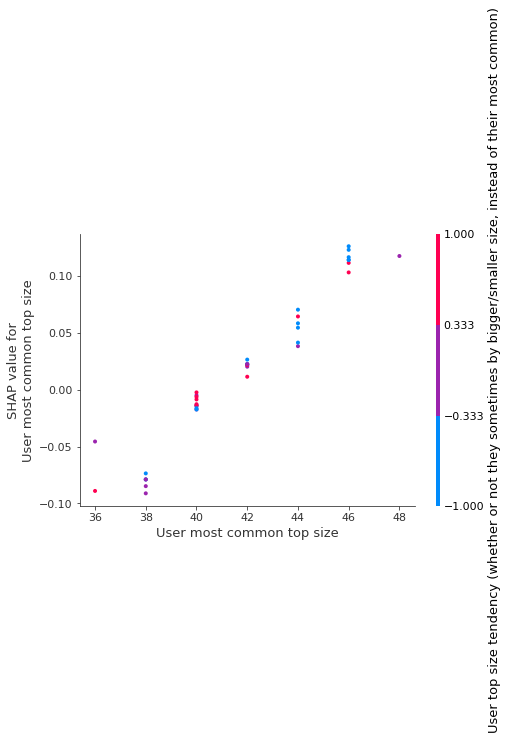

In [20]:
c = 'User most common top size'
shap.dependence_plot(c, shap_values[0], preproceed_test.drop('Happiness', axis=1))

In [21]:
shap.force_plot(explainer.expected_value[0], shap_values[0], feature_names=preproceed_train.columns)#, preproceed_test.iloc[0,:])

In [22]:
# positive example

order_num = 11
# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value[0], shap_values[0][order_num,:],
                preproceed_test.drop('Happiness', axis=1).iloc[order_num,:],  link = 'logit')

In [23]:
# negative example

order_num = 12
shap.force_plot(explainer.expected_value[0], shap_values[0][order_num,:],
                preproceed_test.drop('Happiness', axis=1).iloc[order_num,:],  link = 'logit')

In [24]:
preproceed_test[preproceed_test['Happiness'] == 1]

,User height,User most common top size,User most common bottoms size,Purchased size,User chest shape,User belly shape,User hips shape,User leg shape,User preferred bottoms fit,User preferred tops fit,"User top size tendency (whether or not they sometimes by bigger/smaller size, instead of their most common)","User bottoms size tendency (whether or not they sometimes by bigger/smaller size, instead of their most common)",cat1_Purchased product type_Buksedragter,cat1_Purchased product type_Bukser,cat1_Purchased product type_Kjoler,cat1_Purchased product type_Nederdele,cat1_Purchased product type_T-Shirts,cat1_Purchased product type_Toppe,Happiness
7,164.0,38.0,41.425532,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
24,174.0,38.0,41.425532,36.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
38,175.0,46.0,41.425532,46.0,1.0,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
